In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [5]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O data/sarcasm.json

--2020-07-21 09:01:00--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.28.16, 172.217.30.48, 172.217.162.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5,4M) [application/json]
Saving to: ‘data/sarcasm.json’

data/sarcasm.json   100%[===================>]   5,38M  1,16MB/s    in 5,6s    

2020-07-21 09:01:06 (977 KB/s) - ‘data/sarcasm.json’ saved [5643545/5643545]



In [6]:
with open("data/sarcasm.json", 'r') as f:
    datastore = json.load(f)

In [7]:
sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [8]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [9]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [10]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 24)                408       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [13]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 1s - loss: 0.6646 - accuracy: 0.5920 - val_loss: 0.5848 - val_accuracy: 0.7453
Epoch 2/30
625/625 - 1s - loss: 0.4410 - accuracy: 0.8300 - val_loss: 0.3897 - val_accuracy: 0.8401
Epoch 3/30
625/625 - 1s - loss: 0.3202 - accuracy: 0.8719 - val_loss: 0.3565 - val_accuracy: 0.8509
Epoch 4/30
625/625 - 1s - loss: 0.2680 - accuracy: 0.8967 - val_loss: 0.3452 - val_accuracy: 0.8553
Epoch 5/30
625/625 - 1s - loss: 0.2325 - accuracy: 0.9102 - val_loss: 0.3440 - val_accuracy: 0.8523
Epoch 6/30
625/625 - 1s - loss: 0.2050 - accuracy: 0.9217 - val_loss: 0.3462 - val_accuracy: 0.8541
Epoch 7/30
625/625 - 1s - loss: 0.1843 - accuracy: 0.9309 - val_loss: 0.3535 - val_accuracy: 0.8530
Epoch 8/30
625/625 - 1s - loss: 0.1670 - accuracy: 0.9383 - val_loss: 0.3656 - val_accuracy: 0.8554
Epoch 9/30
625/625 - 1s - loss: 0.1493 - accuracy: 0.9459 - val_loss: 0.4166 - val_accuracy: 0.8366
Epoch 10/30
625/625 - 1s - loss: 0.1367 - accuracy: 0.9510 - val_loss: 0.4026 - val_accuracy: 0.8478

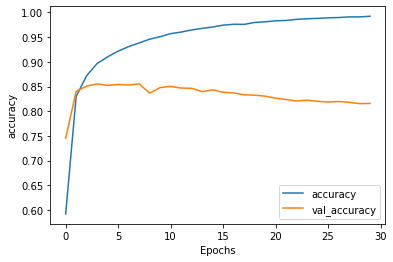

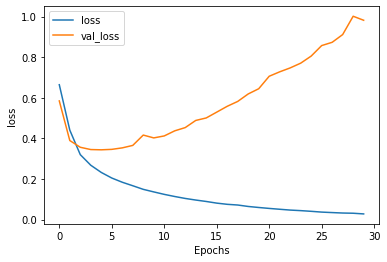

In [14]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [18]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[0]))
print("------------------------------------------------")
print(training_sentences[0])
print("------------------------------------------------")
print(labels[2])

former <OOV> store clerk sues over secret 'black <OOV> for minority shoppers ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
------------------------------------------------
former versace store clerk sues over secret 'black code' for minority shoppers
------------------------------------------------
1


In [19]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [ ]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()